# pySCENIC protocol: organoid data

June 2020

Dataset: organoid from Dominic

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns
import re

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


#### set variables for file paths to read from and write to:

In [2]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/sc_cone_devel/sc_cone_devel_organoid/20181001-DS-organoid-Hs_proj/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/sc_cone_devel/sc_cone_devel_organoid/20181001-DS-organoid-Hs_proj'

In [3]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
#loom_file = 'output/scenic/090520_noLR_noiPSC_nonPRgrp_noSideGrps_seu-final.loom'
loom_file = 'output/scenic/011221_noLR_noiPSC_nonPRgrp_noSideGrps_byUmapPosition_seu-final.loom'
adata_path = re.sub("-final.loom", ".h5ad", loom_file)



In [4]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

## Extract relevant data from the integrated loom file

In [5]:
# scenic output
lf = lp.connect( loom_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [6]:
auc_mtx.head()


ATF4_(+)  BACH2_(+)  CEBPB_(+)  CREB5_(+)   CRX_(+)  \
ds20181001-0001  0.211775   0.049471   0.157993   0.000000  0.150910   
ds20181001-0002  0.102394   0.000597   0.096357   0.101523  0.099648   
ds20181001-0003  0.151524   0.042050   0.114669   0.053672  0.079174   
ds20181001-0004  0.070723   0.000000   0.111406   0.276292  0.043004   
ds20181001-0005  0.119892   0.009596   0.104001   0.196968  0.122731   

                 E2F1_(+)  E2F2_(+)  E2F7_(+)  E2F8_(+)  EGR1_(+)  ...  \
ds20181001-0001  0.003327  0.000000  0.000000  0.000000  0.278427  ...   
ds20181001-0002  0.025320  0.000000  0.000000  0.000000  0.161301  ...   
ds20181001-0003  0.124543  0.143628  0.227073  0.152756  0.252908  ...   
ds20181001-0004  0.264854  0.267733  0.343466  0.200754  0.315041  ...   
ds20181001-0005  0.018095  0.000000  0.000000  0.002404  0.174816  ...   

                 RFX4_(+)  SIX6_(+)  SOX2_(+)  SOX9_(+)  SREBF1_(+)  \
ds20181001-0001  0.000000  0.348601  0.050104  0.043617    0.041112   
ds20181001-0002  0.000000  0.299898  0.058254  0.041914    0.012900   
ds20181001-0003  0.000000  0.070539  0.088260  0.061559    0.018416   
ds20181001-0004  0.071276  0.226629  0.184385  0.173969    0.031816   
ds20181001-0005  0.000000  0.178779  0.072531  0.067374    0.026095   

                 SREBF2_(+)  TCF12_(+)  TLX2_(+)  VSX2_(+)  ZNF281_(+)  
ds20181001-0001    0.081644   0.227567  0.028352  0.046510    0.062104  
ds20181001-0002    0.000000   0.141675  0.081167  0.062375    0.026978  
ds20181001-0003    0.014125   0.221853  0.088485  0.166858    0.029290  
ds20181001-0004    0.000000   0.149693  0.118219  0.319406    0.019804  
ds20181001-0005    0.036233   0.303395  0.095036  0.094452    0.055551  

[5 rows x 45 columns]

In [7]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [8]:
# meta['regulonThresholds']
thresholds.keys().aslist()

AttributeError: 'dict_keys' object has no attribute 'aslist'

In [9]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [10]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [11]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [12]:
regulons.keys()

dict_keys(['ATF4_(+)', 'BACH2_(+)', 'CEBPB_(+)', 'CREB5_(+)', 'CRX_(+)', 'E2F1_(+)', 'E2F2_(+)', 'E2F7_(+)', 'E2F8_(+)', 'EGR1_(+)', 'ESRRG_(+)', 'ETV4_(+)', 'FOS_(+)', 'FOSB_(+)', 'FOXI3_(+)', 'FOXO3_(+)', 'FOXP2_(+)', 'GSC2_(+)', 'HOXB5_(+)', 'JUNB_(+)', 'KDM5B_(+)', 'KLF6_(+)', 'LHX2_(+)', 'LHX4_(+)', 'MEF2C_(+)', 'MEF2D_(+)', 'MYB_(+)', 'NEUROD1_(+)', 'NR2F6_(+)', 'NRL_(+)', 'OTX2_(+)', 'PBX3_(+)', 'PPARA_(+)', 'RAX_(+)', 'RAX2_(+)', 'RFX4_(+)', 'SIX6_(+)', 'SOX2_(+)', 'SOX9_(+)', 'SREBF1_(+)', 'SREBF2_(+)', 'TCF12_(+)', 'TLX2_(+)', 'VSX2_(+)', 'ZNF281_(+)'])

In [13]:
myregulon = 'GSC2_(+)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

'There are 33 genes in GSC2_(+).'

## distribution of number of genes per regulon

In [14]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count     45.000000
mean      77.288889
std      158.606807
min        5.000000
25%       11.000000
50%       24.000000
75%       33.000000
max      873.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [15]:
adata = sc.read( loom_file, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [16]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [17]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [18]:
sc._utils.sanitize_anndata( adata )

... storing 'ClusterID' as categorical
... storing 'Clusterings' as categorical
... storing 'Collection_Method' as categorical
... storing 'Kit_ID' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'Phase' as categorical
... storing 'Prep.Method' as categorical
... storing 'Prep.Number' as categorical
... storing 'Tissue.Type' as categorical
... storing 'batch' as categorical
... storing 'cell_types_1.6' as categorical
... storing 'cell_types_2' as categorical
... storing 'excluded_because' as categorical
... storing 'gene_snn_res.0.2' as categorical
... storing 'gene_snn_res.0.4' as categorical
... storing 'gene_snn_res.0.6' as categorical
... storing 'gene_snn_res.0.8' as categorical
... storing 'gene_snn_res.1' as categorical
... storing 'gene_snn_res.1.2' as categorical
... storing 'gene_snn_res.1.4' as categorical
... storing 'gene_snn_res.1.6' as categorical
... storing 'gene_snn_res.1.6_1' as categorical
... storing 'gene_snn_res.1.8' as categorical

In [19]:

adata.obs.columns

Index(['Age', 'ClusterID', 'Cluster_Color', 'Clusterings', 'Collection_Method',
       'Fetal_Age', 'G2M.Score', 'HR_Cluster_Black', 'HR_Cluster_DG',
       'HR_Cluster_LB', 'HR_Cluster_LG', 'HR_Cluster_Pink', 'Kit_ID',
       'Kit_sample', 'Louvain_clusters_Scanpy', 'Moderate_Alignment',
       'Non_Photoreceptors', 'Old_Seq_Kit_ID', 'Old_Seq_Number', 'Outliers',
       'Percent_mito', 'Phase', 'Poor_Read_Number', 'Possible_Rods',
       'Prep.Method', 'Prep.Number', 'Rod_Cells', 'S.Score', 'Seq_Number',
       'Time.Group', 'Tissue.Type', 'VSX2_Outlier', 'X1', 'X1_1', 'X1_2',
       'X1_3', 'X9_Cluster_Green_Rods', 'batch', 'cell_types_1.6',
       'cell_types_2', 'excluded_because', 'gene_snn_res.0.2',
       'gene_snn_res.0.4', 'gene_snn_res.0.6', 'gene_snn_res.0.8',
       'gene_snn_res.1', 'gene_snn_res.1.2', 'gene_snn_res.1.4',
       'gene_snn_res.1.6', 'gene_snn_res.1.6_1', 'gene_snn_res.1.8',
       'gene_snn_res.2', 'group_names_2', 'louvain', 'nCount_RNA',
       'nCount_ge

In [20]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [21]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [22]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [23]:
# df_motifs = load_motifs('reg.csv')

In [24]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [25]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [26]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


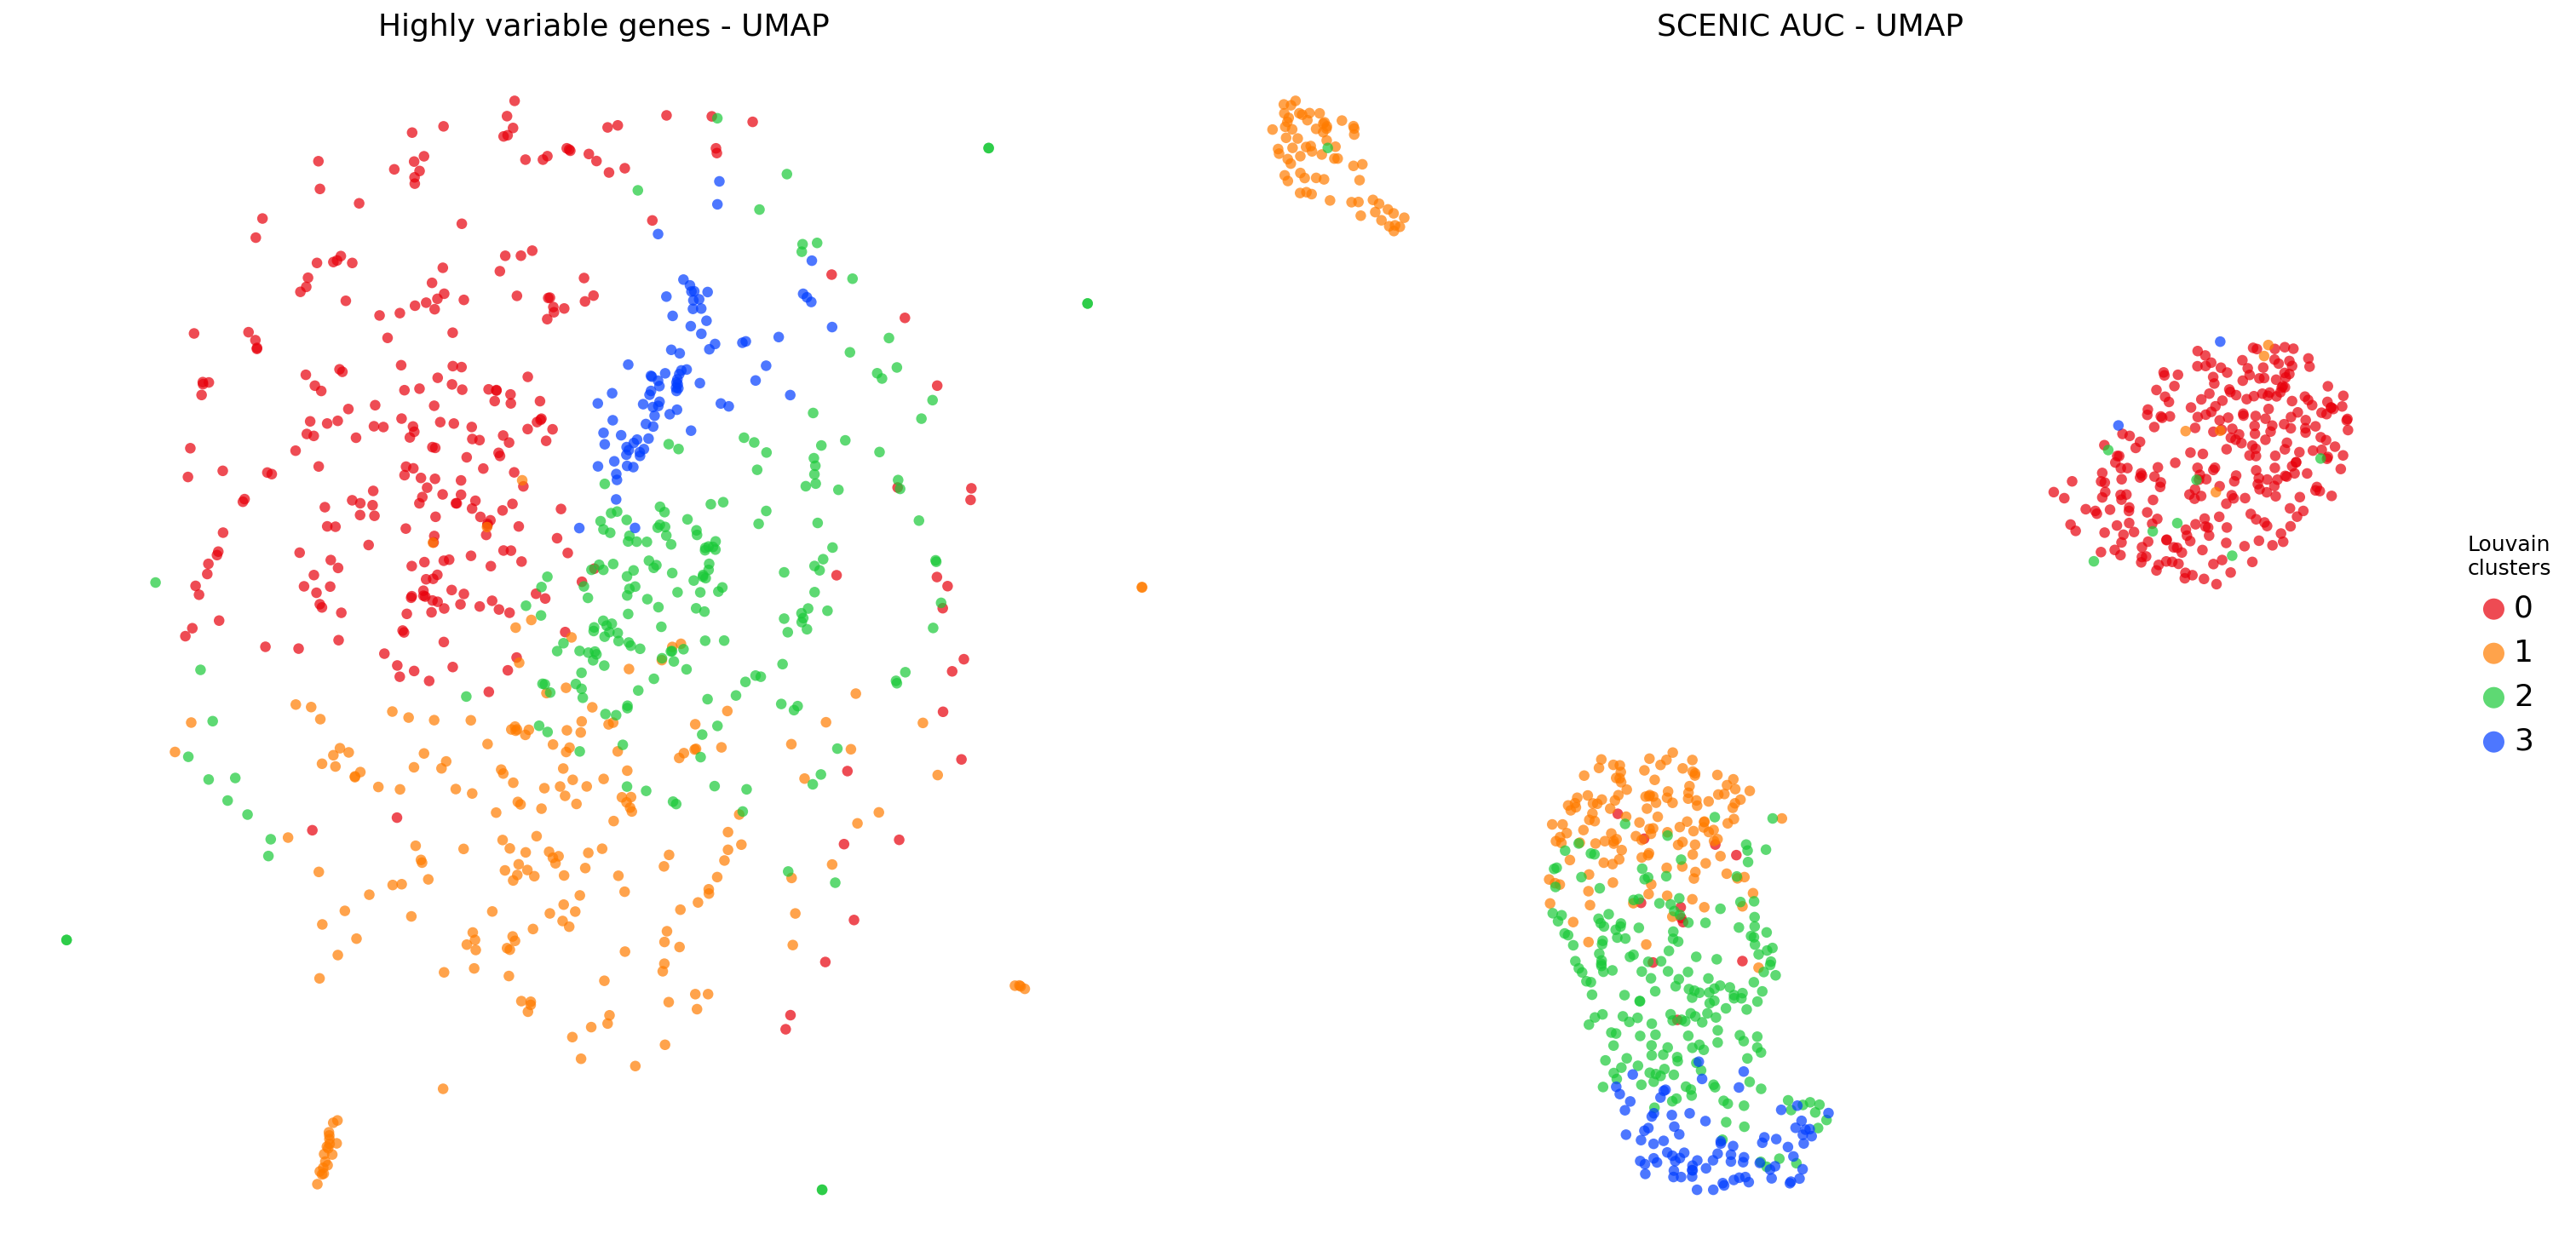

In [27]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [28]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [29]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = cell types at resolution 1.6

In [55]:
metavar="cell_types_2"

In [56]:
cellAnnot

Age ClusterID  Cluster_Color Clusterings Collection_Method  \
ds20181001-0001   56.0         1              2        (1,)              FACS   
ds20181001-0190   56.0         1              2        (1,)              FACS   
ds20181001-0189   56.0         1              2        (1,)              FACS   
ds20181001-0188   56.0         1              2        (1,)              FACS   
ds20181001-0187   56.0         1              2        (1,)              FACS   
...                ...       ...            ...         ...               ...   
ds20181001-0681  139.0         0              2        (0,)              FACS   
ds20181001-0686  140.0         0              2        (0,)                NA   
ds20181001-0690  140.0         0              2        (0,)                NA   
ds20181001-0544  141.0         0              2        (0,)              FACS   
ds20181001-1032  225.0         0              2        (0,)              FACS   

                 Fetal_Age  G2M.Score  HR_Cluster_Black  HR_Cluster_DG  \
ds20181001-0001          2   0.034380                 2              2   
ds20181001-0190          2   0.095966                 2              2   
ds20181001-0189          2   0.050296                 2              2   
ds20181001-0188          2   0.084047                 2              2   
ds20181001-0187          2  -0.019134                 2              2   
...                    ...        ...               ...            ...   
ds20181001-0681          2  -0.024702                 2              2   
ds20181001-0686          2  -0.069106                 2              2   
ds20181001-0690          2   0.042600                 2              2   
ds20181001-0544          2   0.037795                 2              2   
ds20181001-1032          2   0.013754                 2              2   

                 HR_Cluster_LB  ...  transcript_snn_res.0.6  \
ds20181001-0001              2  ...                       3   
ds20181001-0190              2  ...                       3   
ds20181001-0189              2  ...                       3   
ds20181001-0188              2  ...                       3   
ds20181001-0187              2  ...                       3   
...                        ...  ...                     ...   
ds20181001-0681              2  ...                       4   
ds20181001-0686              2  ...                       4   
ds20181001-0690              2  ...                       4   
ds20181001-0544              2  ...                       4   
ds20181001-1032              2  ...                       4   

                 transcript_snn_res.0.8 transcript_snn_res.1  \
ds20181001-0001                       3                    2   
ds20181001-0190                       3                    2   
ds20181001-0189                       3                    2   
ds20181001-0188                       3                    2   
ds20181001-0187                       3                    2   
...                                 ...                  ...   
ds20181001-0681                       4                    3   
ds20181001-0686                       4                    3   
ds20181001-0690                       4                    3   
ds20181001-0544                       4                    3   
ds20181001-1032                       4                    3   

                 transcript_snn_res.1.2 transcript_snn_res.1.4  \
ds20181001-0001                       2                      0   
ds20181001-0190                       8                      9   
ds20181001-0189                       8                      9   
ds20181001-0188                       2                      0   
ds20181001-0187                       8                      9   
...                                 ...                    ...   
ds20181001-0681                       3                      2   
ds20181001-0686                       3                      2   
ds20181001-0690                      

### Calculate RSS

In [57]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] )
rss_louvain

ATF4_(+)  BACH2_(+)  CEBPB_(+)  CREB5_(+)   CRX_(+)  E2F1_(+)  \
Cone2   0.252953   0.221369   0.278976   0.260943  0.274739  0.228655   
Cone1   0.200557   0.189733   0.210094   0.204287  0.208236  0.203891   
RPC/MG  0.224776   0.209305   0.244567   0.395032  0.217176  0.333815   
Cone3   0.248573   0.244460   0.268098   0.237954  0.275923  0.212845   
Rod1    0.311110   0.289558   0.283371   0.250961  0.284303  0.226465   
Cone4   0.239735   0.258356   0.265901   0.231187  0.275815  0.185623   
Cone5   0.248719   0.298263   0.275950   0.233765  0.294261  0.189209   
Cone6   0.234732   0.274790   0.265559   0.193519  0.275428  0.186907   
cRPC    0.188894   0.174027   0.203350   0.271511  0.186743  0.470804   
Rod2    0.334412   0.323913   0.291022   0.245920  0.290116  0.221121   
Rod3    0.389078   0.362606   0.312159   0.267461  0.322551  0.221737   

        E2F2_(+)  E2F7_(+)  E2F8_(+)  EGR1_(+)  ...  RFX4_(+)  SIX6_(+)  \
Cone2   0.221538  0.211248  0.202575  0.281851  ...  0.229846  0.286339   
Cone1   0.189703  0.179528  0.186458  0.210966  ...  0.220659  0.211276   
RPC/MG  0.239645  0.230014  0.306834  0.252389  ...  0.332693  0.225430   
Cone3   0.205989  0.188370  0.202207  0.273870  ...  0.189039  0.288325   
Rod1    0.235909  0.206096  0.190229  0.279010  ...  0.200276  0.251417   
Cone4   0.197306  0.182629  0.183066  0.272989  ...  0.199825  0.297991   
Cone5   0.197508  0.175453  0.181302  0.283131  ...  0.188289  0.330553   
Cone6   0.206427  0.171423  0.171654  0.268587  ...  0.216581  0.306158   
cRPC    0.511287  0.592827  0.569245  0.212583  ...  0.234996  0.198435   
Rod2    0.236479  0.206080  0.195169  0.273558  ...  0.204226  0.238241   
Rod3    0.253477  0.222565  0.193370  0.297266  ...  0.207035  0.232524   

        SOX2_(+)  SOX9_(+)  SREBF1_(+)  SREBF2_(+)  TCF12_(+)  TLX2_(+)  \
Cone2   0.296126  0.287138    0.260213    0.255863   0.300420  0.237528   
Cone1   0.223248  0.219137    0.205098    0.202984   0.223436  0.192763   
RPC/MG  0.373969  0.388548    0.246981    0.207363   0.247884  0.210980   
Cone3   0.254907  0.252261    0.266469    0.272354   0.296456  0.258167   
Rod1    0.273061  0.271311    0.309896    0.280574   0.272815  0.260561   
Cone4   0.235819  0.235699    0.260251    0.276039   0.279370  0.283467   
Cone5   0.229592  0.231932    0.275201    0.298016   0.297415  0.329541   
Cone6   0.216013  0.219200    0.243639    0.255131   0.264554  0.315116   
cRPC    0.271917  0.270215    0.199077    0.181232   0.207251  0.189741   
Rod2    0.256949  0.256607    0.314024    0.301959   0.243875  0.280864   
Rod3    0.267518  0.260983    0.314849    0.302557   0.238984  0.315420   

        VSX2_(+)  ZNF281_(+)  
Cone2   0.280340    0.271645  
Cone1   0.226849    0.208133  
RPC/MG  0.479768    0.231226  
Cone3   0.209250    0.279655  
Rod1    0.219633    0.308317  
Cone4   0.195396    0.269440  
Cone5   0.175482    0.283961  
Cone6   0.173130    0.252426  
cRPC    0.344429    0.191162  
Rod2    0.203498    0.299980  
Rod3    0.209967    0.301643  

[11 rows x 45 columns]

In [58]:
rss_louvain.to_csv('output/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

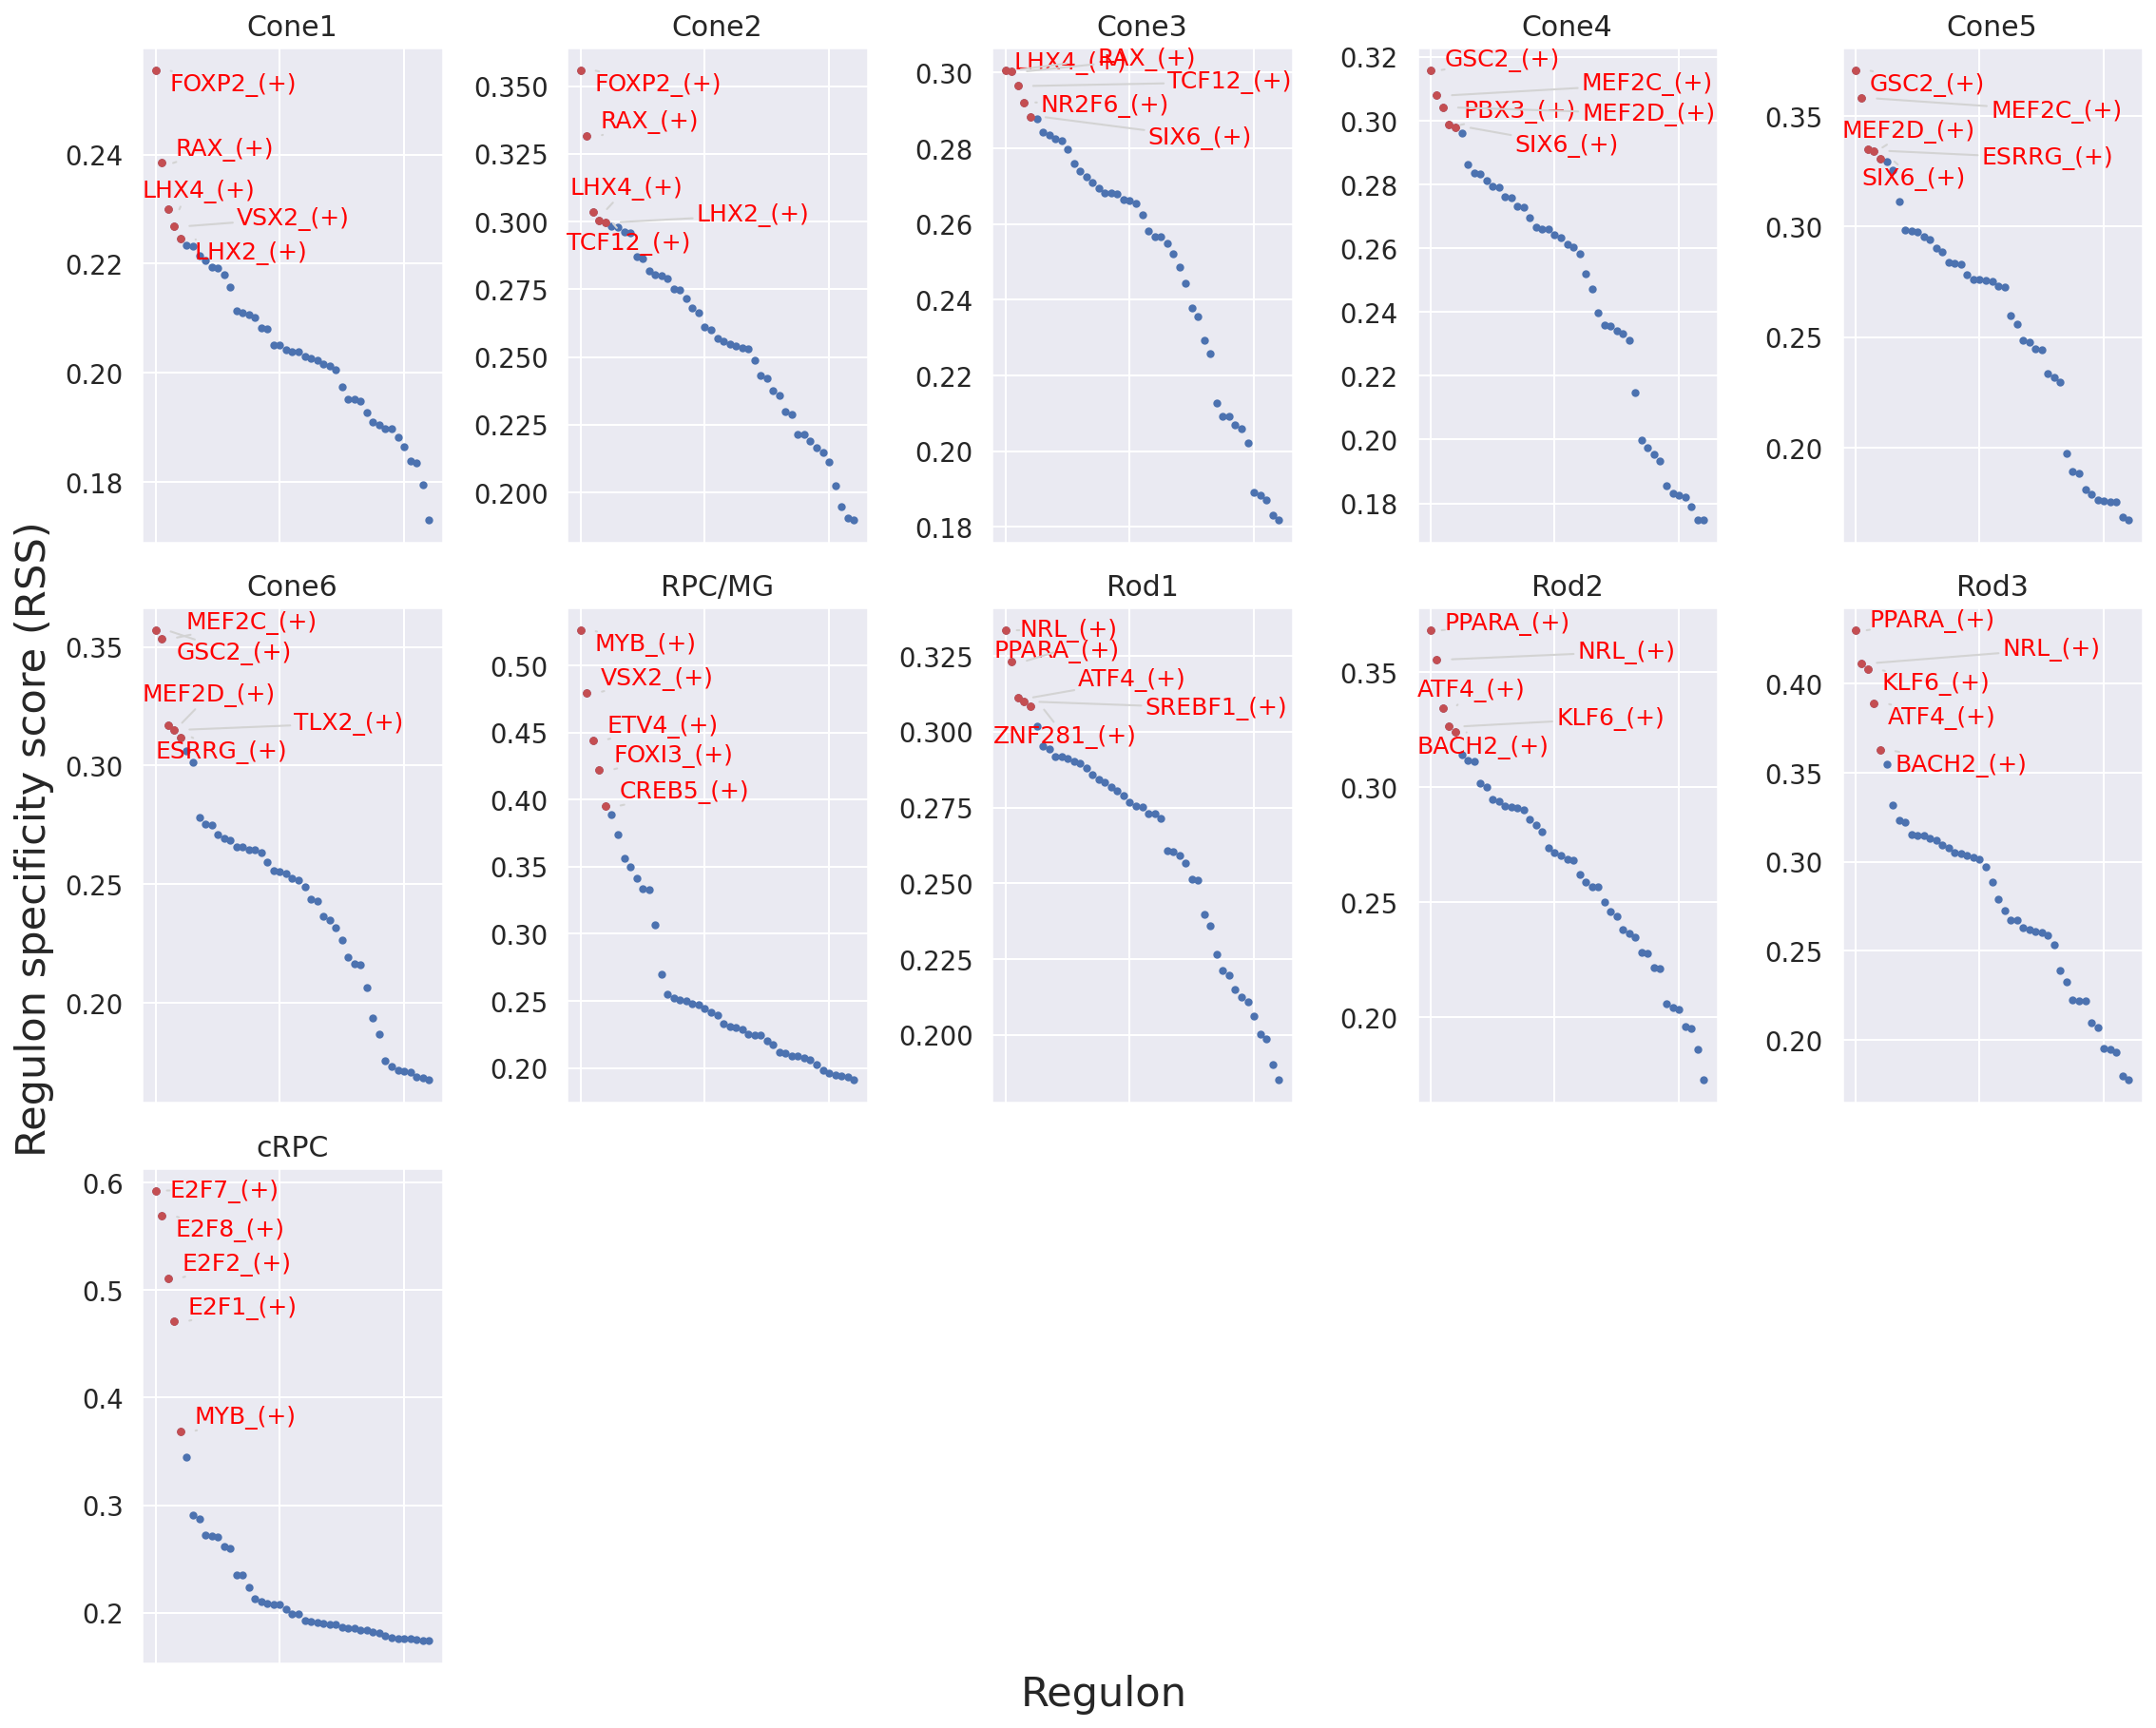

In [59]:
# cats = sorted( list(set(cellAnnot[metavar].dropna())), key=int )
cats = sorted( list(set(cellAnnot[metavar].dropna())) )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [60]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [61]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby(metavar)[topreg].mean()
mean_regulon_by_meta

E2F2_(+)  PPARA_(+)  ZNF281_(+)  TCF12_(+)  ETV4_(+)  ATF4_(+)  \
cell_types_2                                                                   
Cone1         0.006505   0.010386    0.061214   0.230443  0.004093  0.149592   
Cone2         0.006846   0.018499    0.064393   0.228088  0.002789  0.157309   
Cone3         0.005637   0.040015    0.089955   0.270897  0.002067  0.183912   
Cone4         0.004708   0.055915    0.090708   0.261760  0.001122  0.182968   
Cone5         0.004621   0.109863    0.099622   0.293024  0.000953  0.196264   
Cone6         0.006831   0.119143    0.082381   0.247005  0.000092  0.191422   
RPC/MG        0.014629   0.037934    0.055764   0.194183  0.050483  0.156355   
Rod1          0.009663   0.195342    0.110274   0.200070  0.001745  0.354603   
Rod2          0.010107   0.288359    0.109049   0.145910  0.007085  0.462569   
Rod3          0.010700   0.316378    0.086399   0.104123  0.002540  0.520136   
cRPC          0.228105   0.021102    0.039658   0.187567  0.039110  0.112414   

              SIX6_(+)  NR2F6_(+)  PBX3_(+)  TLX2_(+)  ...  E2F8_(+)  \
cell_types_2                                           ...             
Cone1         0.209687   0.199838  0.090200  0.084847  ...  0.004069   
Cone2         0.240908   0.223463  0.111057  0.094684  ...  0.003494   
Cone3         0.296484   0.267610  0.206040  0.160671  ...  0.004258   
Cone4         0.375016   0.321325  0.271591  0.252970  ...  0.001962   
Cone5         0.458848   0.344051  0.319327  0.358798  ...  0.001616   
Cone6         0.458412   0.303361  0.318190  0.392350  ...  0.000515   
RPC/MG        0.156634   0.096794  0.042691  0.084482  ...  0.023420   
Rod1          0.181762   0.205908  0.106303  0.155119  ...  0.002336   
Rod2          0.156423   0.203151  0.173224  0.213103  ...  0.003067   
Rod3          0.113426   0.148855  0.227698  0.230642  ...  0.002531   
cRPC          0.164410   0.068159  0.033959  0.089946  ...  0.212733   

              GSC2_(+)  MEF2C_(+)  FOXI3_(+)  E2F1_(+)  BACH2_(+)  E2F7_(+)  \
cell_types_2                                                                  
Cone1         0.083281   0.058891   0.032069  0.012248   0.053839  0.002854   
Cone2         0.111910   0.073444   0.020386  0.008253   0.054566  0.004563   
Cone3         0.196920   0.145070   0.018939  0.007157   0.101717  0.002676   
Cone4         0.317232   0.243310   0.006840  0.003075   0.142357  0.001935   
Cone5         0.441067   0.329481   0.005481  0.003315   0.207423  0.000880   
Cone6         0.499626   0.395378   0.001722  0.003421   0.196837  0.000532   
RPC/MG        0.052525   0.037836   0.175857  0.046386   0.063202  0.011143   
Rod1          0.054995   0.054396   0.041245  0.009289   0.166836  0.004316   
Rod2          0.075447   0.076858   0.032735  0.008749   0.244251  0.004888   
Rod3          0.116394   0.140926   0.023476  0.007324   0.252830  0.005949   
cRPC          0.047944   0.022369   0.148744  0.228901   0.020809  0.232708   

              KLF6_(+)  MEF2D_(+)  VSX2_(+)  
cell_types_2                                 
Cone1         0.094917   0.070226  0.058034  
Cone2         0.085638   0.113396  0.045036  
Cone3         0.081659   0.201633  0.017181  
Cone4         0.100052   0.284580  0.012448  
Cone5         0.110939   0.340734  0.003079  
Cone6         0.119196   0.363936  0.002833  
RPC/MG        0.128760   0.053552  0.259439  
Rod1          0.153788   0.140268  0.021113  
Rod2          0.251133   0.168510  0.014796  
Rod3          0.335144   0.147106  0.014216  
cRPC          0.050021   0.027758  0.280903  

[11 rows x 29 columns]

#### Generate a Z-score for each regulon to enable comparison between regulons

In [62]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [63]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [64]:
# cellAnnot.index = cellAnnot.index.str.replace("ds20170407_S", "ds20170407-")
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['ds20181001-0923', 'ds20181001-0566', 'ds20181001-0567',
       'ds20181001-0580', 'ds20181001-0577', 'ds20181001-0575',
       'ds20181001-0574', 'ds20181001-0936', 'ds20181001-0193',
       'ds20181001-0573',
       ...
       'ds20181001-0786', 'ds20181001-0913', 'ds20181001-0860',
       'ds20181001-0773', 'ds20181001-0611', 'ds20181001-0613',
       'ds20181001-0003', 'ds20181001-0043', 'ds20181001-0406',
       'ds20181001-0927'],
      dtype='object', length=786)

In [65]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [66]:
cats

['Cone1',
 'Cone2',
 'Cone3',
 'Cone4',
 'Cone5',
 'Cone6',
 'RPC/MG',
 'Rod1',
 'Rod2',
 'Rod3',
 'cRPC']

In [67]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar].dropna() ]

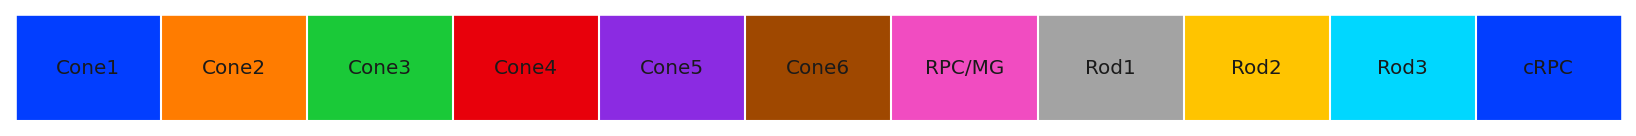

In [68]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -113.05833333333341, '')

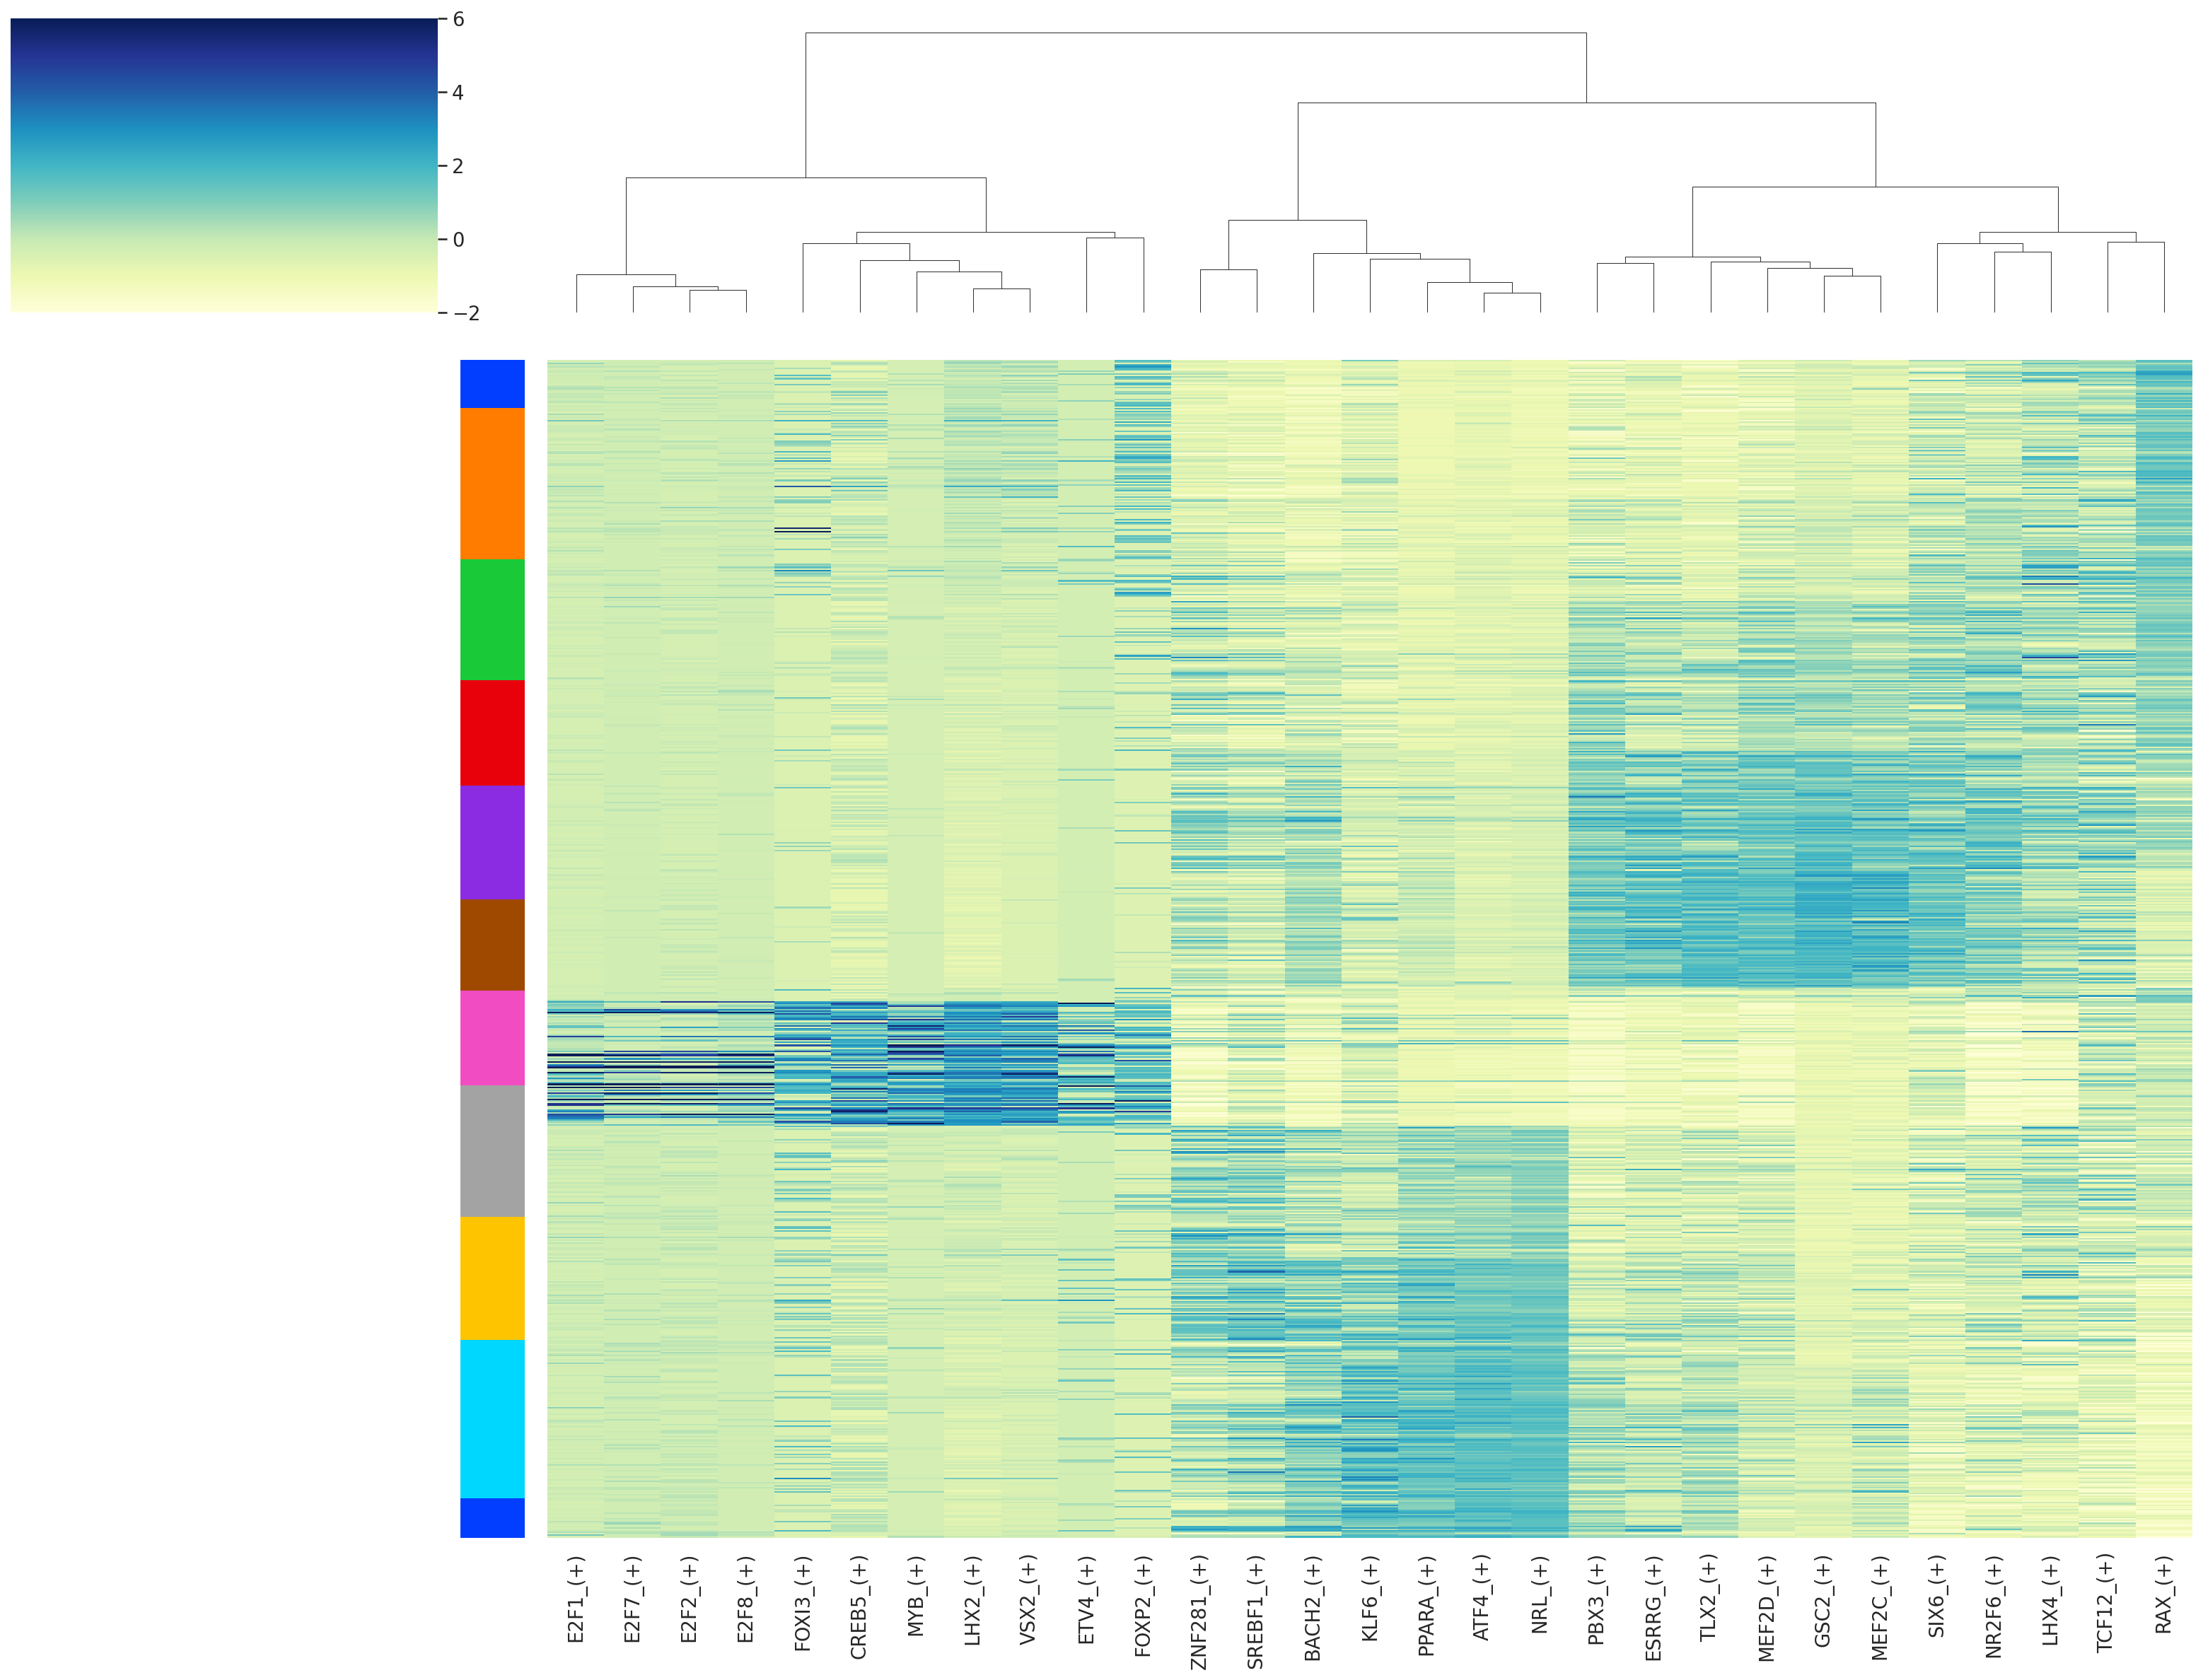

In [69]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [70]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [71]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000017


In [72]:
binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
binary_mtx.head()

ATF4_(+)  BACH2_(+)  CEBPB_(+)  CREB5_(+)  CRX_(+)  E2F1_(+)  \
ds20181001-0923         0          0          0          0        0         0   
ds20181001-0566         0          0          0          0        0         0   
ds20181001-0567         0          0          0          0        0         0   
ds20181001-0580         0          0          0          0        0         0   
ds20181001-0577         0          0          0          0        0         0   

                 E2F2_(+)  E2F7_(+)  E2F8_(+)  EGR1_(+)  ...  RFX4_(+)  \
ds20181001-0923         0         0         0         0  ...         0   
ds20181001-0566         0         0         0         0  ...         0   
ds20181001-0567         0         0         0         0  ...         0   
ds20181001-0580         0         0         0         0  ...         0   
ds20181001-0577         0         0         0         0  ...         1   

                 SIX6_(+)  SOX2_(+)  SOX9_(+)  SREBF1_(+)  SREBF2_(+)  \
ds20181001-0923         0         0         0           0           0   
ds20181001-0566         0         0         0           0           1   
ds20181001-0567         0         0         0           0           0   
ds20181001-0580         0         0         0           0           0   
ds20181001-0577         0         0         0           0           0   

                 TCF12_(+)  TLX2_(+)  VSX2_(+)  ZNF281_(+)  
ds20181001-0923          0         0         0           0  
ds20181001-0566          0         0         0           0  
ds20181001-0567          0         0         0           0  
ds20181001-0580          0         0         0           0  
ds20181001-0577          0         0         0           0  

[5 rows x 45 columns]

### Show the AUC distributions for selected regulons

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

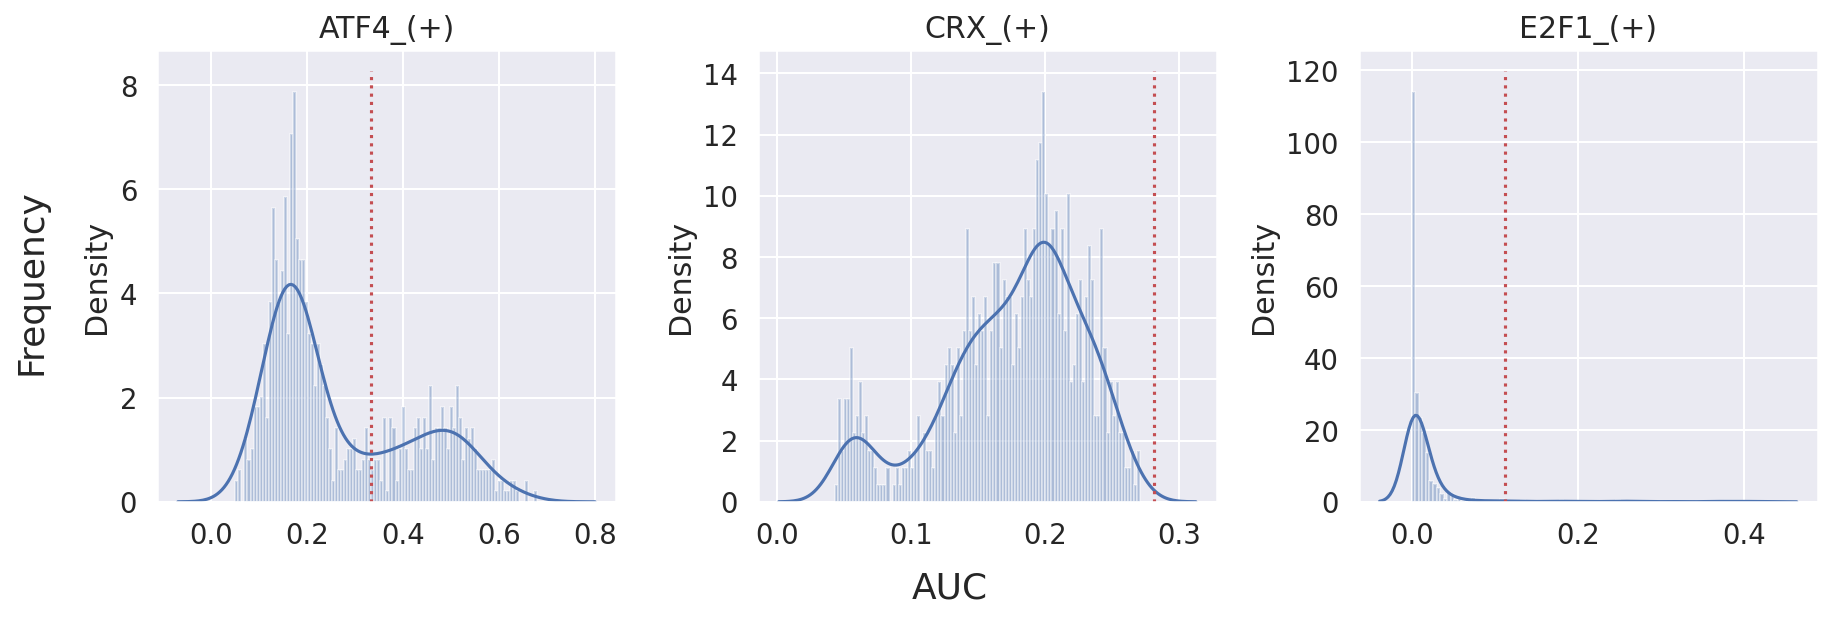

In [73]:
# select regulons:
r = [ 'ATF4_(+)', 'CRX_(+)', 'E2F1_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('PBMC10k_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

# display regulon scores on umap

In [74]:
adata_h5ad = sc.read_h5ad(adata_path)

In [75]:
adata_h5ad.obs[auc_mtx.columns] = auc_mtx

In [76]:
adata_h5ad.obs

orig.ident    nCount_RNA  nFeature_RNA                X1  \
ds20181001-0001  ds20181001  2.764616e+06          9276  ds20181001_S0001   
ds20181001-0002  ds20181001  1.023975e+06          6286  ds20181001_S0002   
ds20181001-0003  ds20181001  2.058744e+06          9785  ds20181001_S0003   
ds20181001-0004  ds20181001  2.809693e+06          9426  ds20181001_S0004   
ds20181001-0005  ds20181001  2.057164e+06          7560  ds20181001_S0005   
...                     ...           ...           ...               ...   
ds20181001-1027  ds20181001  3.408051e+06          7397  ds20181001_S1027   
ds20181001-1028  ds20181001  3.085908e+06          7735  ds20181001_S1028   
ds20181001-1030  ds20181001  3.589266e+06          7362  ds20181001_S1030   
ds20181001-1031  ds20181001  4.432681e+06          8390  ds20181001_S1031   
ds20181001-1032  ds20181001  3.615908e+06          8084  ds20181001_S1032   

                       sample_id tissue_type Kit_ID  Kit_sample  Seq_Number  \
ds20181001-0001  ds20181001-0001    organoid     1A         1.0         3.0   
ds20181001-0002  ds20181001-0002    organoid     1A         2.0         3.0   
ds20181001-0003  ds20181001-0003    organoid     1A         3.0         3.0   
ds20181001-0004  ds20181001-0004    organoid     1A         4.0         3.0   
ds20181001-0005  ds20181001-0005    organoid     1A         5.0         3.0   
...                          ...         ...    ...         ...         ...   
ds20181001-1027  ds20181001-1027    organoid     3C        67.0         3.0   
ds20181001-1028  ds20181001-1028    organoid     3C        68.0         3.0   
ds20181001-1030  ds20181001-1030    organoid     3C        70.0         3.0   
ds20181001-1031  ds20181001-1031    organoid     3C        71.0         3.0   
ds20181001-1032  ds20181001-1032    organoid     3C        72.0         3.0   

                Tissue.Type  ...  RFX4_(+)  SIX6_(+)  SOX2_(+)  SOX9_(+)  \
ds20181001-0001    Organoid  ...  0.000000  0.348601  0.050104  0.043617   
ds20181001-0002    Organoid  ...  0.000000  0.299898  0.058254  0.041914   
ds20181001-0003    Organoid  ...  0.000000  0.070539  0.088260  0.061559   
ds20181001-0004    Organoid  ...  0.071276  0.226629  0.184385  0.173969   
ds20181001-0005    Organoid  ...  0.000000  0.178779  0.072531  0.067374   
...                     ...  ...       ...       ...       ...       ...   
ds20181001-1027    Organoid  ...  0.000000  0.041283  0.041339  0.037660   
ds20181001-1028    Organoid  ...  0.043547  0.107045  0.029296  0.025342   
ds20181001-1030    Organoid  ...  0.000000  0.123422  0.038060  0.029071   
ds20181001-1031    Organoid  ...  0.000000  0.222791  0.046487  0.030206   
ds20181001-1032    Organoid  ...  0.000000  0.034971  0.036814  0.030974   

                 SREBF1_(+)  SREBF2_(+)  TCF12_(+)  TLX2_(+)  VSX2_(+)  \
ds20181001-0001    0.041112    0.081644   0.227567  0.028352  0.046510   
ds20181001-0002    0.012900    0.000000   0.141675  0.081167  0.062375   
ds20181001-0003    0.018416    0.014125   0.221853  0.088485  0.166858   
ds20181001-0004    0.031816    0.000000   0.149693  0.118219  0.319406   
ds20181001-0005    0.026095    0.036233   0.303395  0.095036  0.094452   
...                     ...         ...        ...       ...       ...   
ds20181001-1027    0.072793    0.140566   0.090669  0.203429  0.006899   
ds20181001-1028    0.074404    0.148277   0.134766  0.235875  0.019468   
ds20181001-1030    0.077101    0.294507   0.063545  0.320164  0.033081   
ds20181001-1031    0.077987    0.134255   0.000000  0.119703  0.000000   
ds20181001-1032    0.083581    0.153941   0.088536  0.294268  0.030563   

                ZNF281_(+)  
ds20181001-0001   0.062104  
ds20181001-0002   0.026978  
ds20181001-0003   0.029290  
ds20181001-0004   0.019804  
ds20181001-0005   0.055551  
...                    ...  
ds20181001-1027   0.100901  
ds20181001-1028   0.056648  
ds20181001-1030   0.075745  
ds20181001-1031   0.079714  
ds20181001-1032   0.09

In [77]:
# mean_regulon_by_meta.loc[:,"CREB3_(+)"]

... storing 'orig.ident' as categorical
... storing 'tissue_type' as categorical
... storing 'Kit_ID' as categorical
... storing 'Tissue.Type' as categorical
... storing 'Prep.Method' as categorical
... storing 'Prep.Number' as categorical
... storing 'Collection_Method' as categorical
... storing 'excluded_because' as categorical
... storing 'batch' as categorical
... storing 'type' as categorical
... storing 'gene_snn_res.0.2' as categorical
... storing 'gene_snn_res.0.4' as categorical
... storing 'gene_snn_res.0.6' as categorical
... storing 'gene_snn_res.0.8' as categorical
... storing 'gene_snn_res.1' as categorical
... storing 'gene_snn_res.1.2' as categorical
... storing 'gene_snn_res.1.4' as categorical
... storing 'gene_snn_res.1.6' as categorical
... storing 'gene_snn_res.1.8' as categorical
... storing 'gene_snn_res.2' as categorical
... storing 'Phase' as categorical
... storing 'cell_types_1.6' as categorical
... storing 'gene_snn_res.1.6_1' as categorical
... storing 'gr

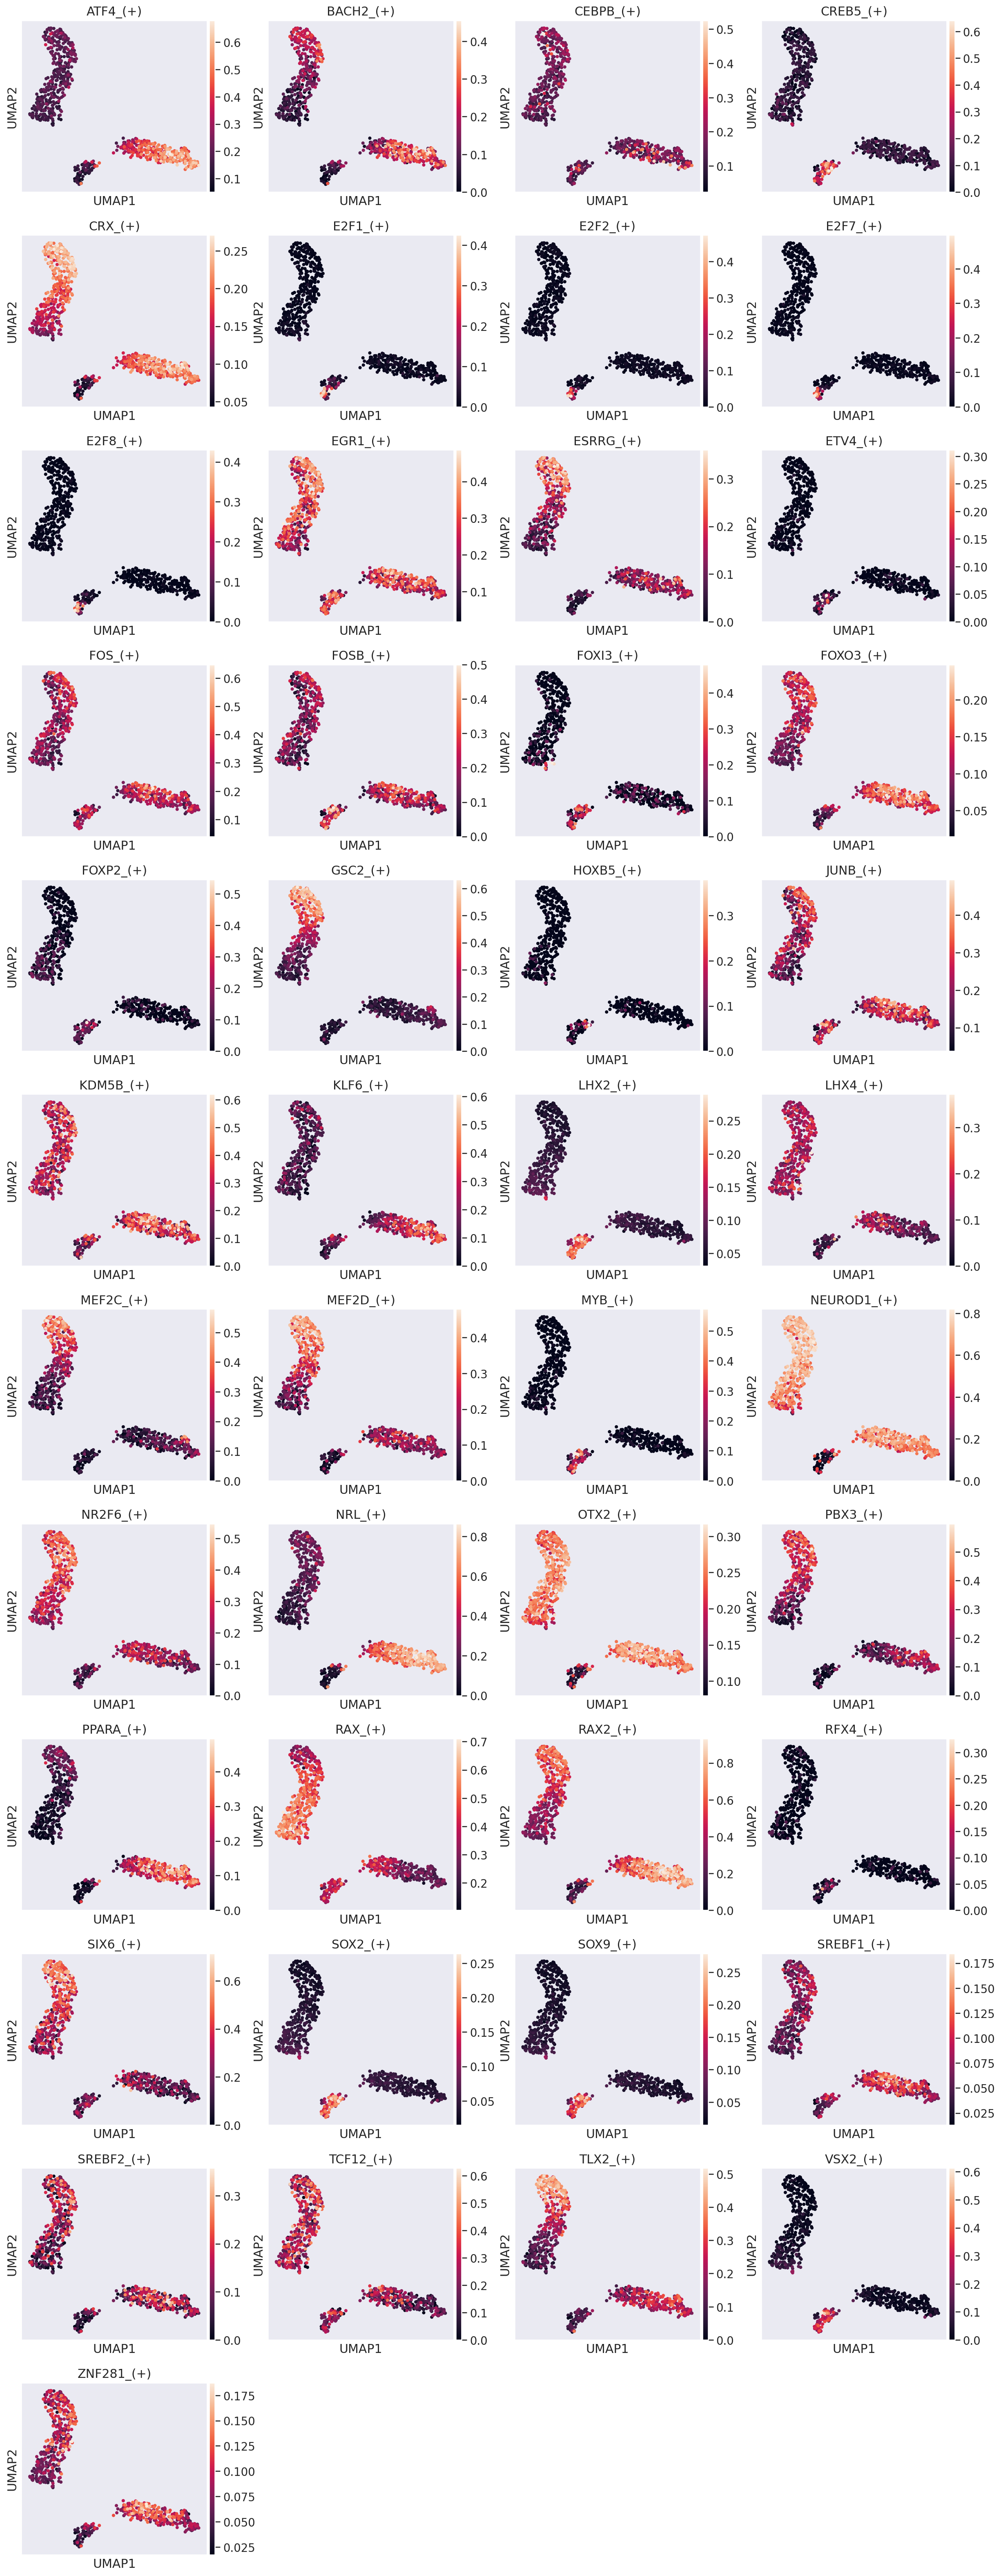

In [78]:
sc.pl.umap(adata_h5ad, color=auc_mtx.columns, size=60, save='.pdf')